In [103]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import os
import warnings

import seaborn as sns
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')
%matplotlib inline
from helpersNeuronalNet import*

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Analysis

In [104]:
from helpersNeuronalNet import*
DATA_TRAIN_PATH = "data/data_train.csv"
data = load_data(DATA_TRAIN_PATH)


DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [105]:
data_train, data_test,n_movies, n_users = split(data)

## Analysis  on the ratings given by user

In [106]:
def human (num, units = 'K'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + "K"
    elif units == 'm':
        return str(num/10**6) + "M"
    elif units == 'b':
        return str(num/10**9) + "B"

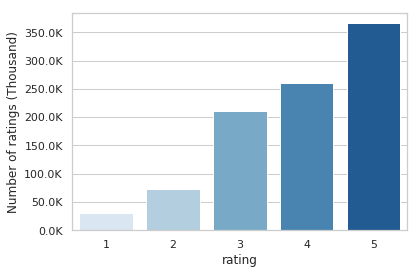

In [107]:
fig, ax = plt.subplots()
sns.countplot(data_train.rating, palette="Blues")
ax.set_yticklabels([human(item, 'K') for item in ax.get_yticks()])
ax.set_ylabel('Number of ratings (Thousand)')
plt.show()
fig.savefig('RatingsDistribution.png')

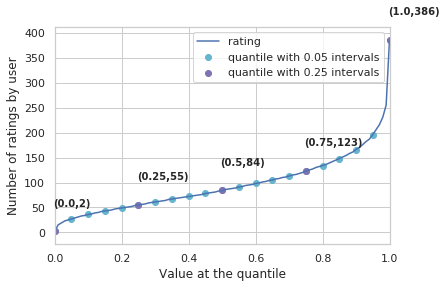

In [108]:
no_of_rated_movies_per_user = data_train.groupby(by='user_id')['rating'].count().sort_values(ascending = False)
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')


quantiles.plot()
plt.scatter (x = quantiles.index[::5], y = quantiles.values[::5], c='c', label = "quantile with 0.05 intervals")
plt.scatter (x = quantiles.index[::25], y = quantiles.values[::25], c='m', label = "quantile with 0.25 intervals")
plt.ylabel('Number of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc = 'best')

for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({},{})".format(x,y),xy=(x,y),xytext=(x-0.005,y+50), fontweight ='bold' )

plt.savefig('quantiles.png')
plt.show()


In [109]:
quantiles [::5]
# 10% of users rated more then 189 movies

0.00      2
0.05     27
0.10     36
0.15     43
0.20     49
0.25     55
0.30     61
0.35     67
0.40     72
0.45     78
0.50     84
0.55     91
0.60     98
0.65    105
0.70    113
0.75    123
0.80    134
0.85    148
0.90    166
0.95    196
1.00    386
Name: rating, dtype: int64

In [79]:
print('\n No of ratings at last 10 percentile: {}\n'.format(sum(no_of_rated_movies_per_user>=189)))


 No of ratings at last 10 percentile: 1011



## Analysis of ratings of a movie given by a user

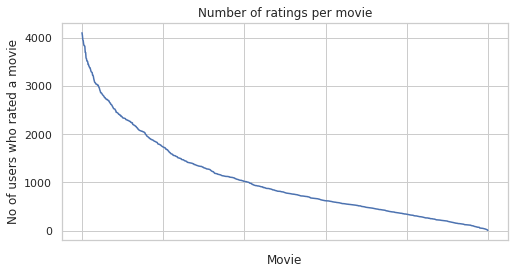

In [83]:
no_of_ratings_per_movie = data_train.groupby(by='movie_id')['rating'].count().sort_values(ascending = False)

fig = plt.figure(figsize = plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of ratings per movie')
plt.xlabel('Movie')
plt.ylabel('No of users who rated a movie')
ax.set_xticklabels([])

plt.savefig('Number of ratings per movie')
plt.show()

In [118]:
average_per_user = data_train.groupby(by=['user_id'])['rating'].mean()
average_per_movie = data_train.groupby(by=['movie_id'])['rating'].mean()
average_per_user.values

array([4.33333333, 3.79069767, 3.37142857, ..., 3.54545455, 3.60606061,
       3.85714286])

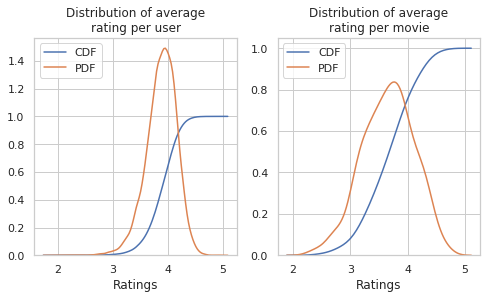

In [125]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.5))

ax1.set_title('Distribution of average\nrating per user')
user_averages = [rat for rat in average_per_user.values]
sns.distplot(user_averages, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(user_averages, ax = ax1, hist = False, label = 'PDF')
ax1.set_xlabel('Ratings')

ax2.set_title('Distribution of average\nrating per movie')
movie_averages = [rat for rat in average_per_movie.values]
sns.distplot(movie_averages, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(movie_averages, ax = ax2, hist = False, label = 'PDF')
ax2.set_xlabel('Ratings')

plt.savefig('AvgRatingsUserMovie.png')
plt.show()
